In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

### Train & Val Split

In [29]:
tensor = np.load("embedding_new.npy")
# tensor = np.load("onehot.npy")
y = pd.read_csv("label.csv")["label"]

In [30]:
y -= 1
y.unique()

array([1, 2, 0])

In [31]:
X_train, y_train = tensor[:170], y[:170]
X_val, y_val = tensor[170:190], y[170:190]
X_test, y_test = tensor[190:], y[190:]
X_train.shape

(170, 75, 8)

In [32]:
X_train[0][0]

array([ 2.3279645,  1.1193714,  1.3651992,  1.4757956,  1.2556211,
       -0.576183 , -0.520399 ,  1.6278158], dtype=float32)

### Transformer

In [33]:
import tensorflow as tf
import seaborn as sns
print(tf.test.gpu_device_name())
from numpy.random import seed
from tensorflow import keras
from tensorflow.keras import layers

/device:GPU:0


In [52]:
### 8(35) 10(33) 12(SoTA, 1e-3) (8,12)
## (42, 0) (12, 100) (12, 12) (42, 100)

RANDOM = 42
import os
os.environ['PYTHONHASHSEED']=str(RANDOM)
import random
random.seed(RANDOM)
import numpy as np
np.random.seed(RANDOM)

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    seed(RANDOM)
    tf.random.set_seed(RANDOM)
    np.random.seed(RANDOM)
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Dense(256, activation="relu", kernel_regularizer='l2')(x)    
    x = layers.Dense(128, activation="relu", kernel_regularizer='l2')(x)
    x = layers.Dense(inputs.shape[-1])(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
    n_classes = 3
):
    tf.random.set_seed(RANDOM)
    seed(RANDOM)
    np.random.seed(RANDOM)
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)

    x = layers.Dense(128, activation="relu", kernel_regularizer='l2')(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

RANDOM = 0
import os
os.environ['PYTHONHASHSEED']=str(RANDOM)
import random
random.seed(RANDOM)
import numpy as np
np.random.seed(RANDOM)

input_shape = X_train.shape[1:]
seed(RANDOM)
tf.random.set_seed(RANDOM)
np.random.seed(RANDOM)
model = build_model(
    input_shape,
    head_size=5,
    num_heads=2,
    ff_dim=3,
    num_transformer_blocks=12,
    mlp_units=[128],
    mlp_dropout=0,
    dropout=0,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    metrics=["accuracy"],
)
history = model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=1000, restore_best_weights=True)]

curve = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=500,
    batch_size=64,
)

model.evaluate(X_test, y_test, verbose=10)    


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 75, 8)]      0           []                               
                                                                                                  
 layer_normalization_84 (LayerN  (None, 75, 8)       16          ['input_8[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_84 (Multi  (None, 75, 8)       358         ['layer_normalization_84[0][0]', 
 HeadAttention)                                                   'layer_normalization_84[0][0]'] 
                                                                                            

[5.703834056854248, 0.36538460850715637]

In [53]:
model.evaluate(X_val, y_val, verbose=10)  

[3.7201743125915527, 0.44999998807907104]

In [54]:
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score
import seaborn as sns
# import torch.nn.functional as nnf
# model.eval()
pred = model(X_test)
# pred = bestcnn(X_test)
pred_prob = tf.nn.softmax(pred, axis=1)

fpr = {}
tpr = {}
thresh ={}      
n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)

a = []
classes = [0,1,2]
for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = pd.DataFrame()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = pred_prob[:, i]
    df_aux = df_aux.reset_index(drop = True)

    
    # Calculates the ROC AUC OvR
    a.append(round(roc_auc_score(df_aux['class'], df_aux['prob']),3))
    print(roc_auc_score(df_aux['class'], df_aux['prob']))

0.7843137254901961
0.31092436974789917
0.33986928104575165


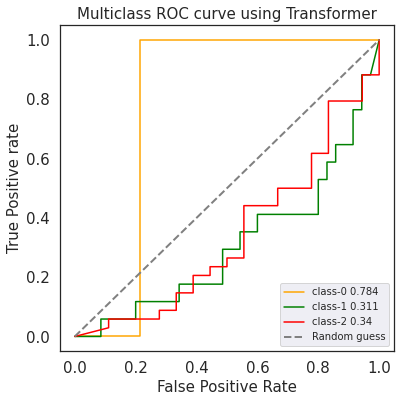

In [55]:
import matplotlib.pyplot as plt

sns.set_style("white")
plt.plot(fpr[0], tpr[0], linestyle='-',color='orange', label=f'class-0 {a[0]}')
plt.plot(fpr[1], tpr[1], linestyle='-',color='green', label=f'class-1 {a[1]}')
plt.plot(fpr[2], tpr[2], linestyle='-',color='red', label=f'class-2 {a[2]}')
# plt.plot(fpr[3], tpr[3], linestyle='-',color='blue', label=f'class-3 {a[3]}')
plt.title('Multiclass ROC curve using Transformer',fontsize=15)
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive rate',fontsize=15)
plt.tick_params(labelsize=15)
sns.set(rc={'figure.figsize':(6,6)})
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey', label='Random guess')
# plt.legend(loc='best',fontsize=10)
plt.legend(loc="lower right", fontsize=10);
plt.savefig("transformer.pdf",dpi=300);

In [47]:
from sklearn.metrics import classification_report
y_true = y_test
y_pred = np.argmax(model(X_test), axis=1)
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00         1
     class 1       0.00      0.00      0.00        17
     class 2       0.65      1.00      0.79        34

    accuracy                           0.65        52
   macro avg       0.22      0.33      0.26        52
weighted avg       0.43      0.65      0.52        52



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# bestmodel = keras.models.load_model("drive/MyDrive/model_transformer_final")

In [ ]:
def extract(arr):
  out = []
  for weights in arr:
    max_weights = np.argmax(weights)
    out.append(max_weights)
  return out

In [ ]:
import matplotlib.pyplot as plt
sns.set_style("white")
plt.plot(curve.history['loss'][0:1000])
plt.plot(curve.history['val_loss'][0:1000])
plt.title("Loss Curve of Transformer-based Model",fontsize=15)
plt.ylabel('loss',fontsize=15)
plt.xlabel('epoch',fontsize=15)
plt.tick_params(labelsize=15)
sns.set(rc={'figure.figsize':(6,6)})
# plt.ylim(0.8, 2.2)
plt.legend(['train', "validation"], loc='upper right')
plt.savefig("transformer_loss.pdf",dpi=300);
# plt.show()

In [ ]:
plt.plot(curve.history['accuracy'])
plt.plot(curve.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(curve.history['loss'][:500])
plt.plot(curve.history['val_loss'][:500])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()